# Pytorch Tensorboard

* [how-to-use-tensorboard-with-pytorch](https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-tensorboard-with-pytorch.md)
* [Pytorch TensorBoard Tutorial](https://www.youtube.com/watch?v=RLqsxWaQdHE)
* [Using Tensorboard in Pytorch](https://krishansubudhi.github.io/deeplearning/2020/03/24/tensorboard-pytorch.html)

## Training examples

[Training with PyTorch](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html)

> For this tutorial, we’ll be using the Fashion-MNIST dataset provided by TorchVision. We use torchvision.transforms.Normalize() to zero-center and normalize the distribution of the image tile content, and download both training and validation data splits.

* [Kaggle - Fashion MNIST with Pytorch](https://www.kaggle.com/code/pankajj/fashion-mnist-with-pytorch-93-accuracy)

In [1]:
import os
import sys
from itertools import (
    product
)
from typing import (
    List,
    Union,
)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix
)
import torch
from torch import nn
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.tensorboard import (
    SummaryWriter,
)

In [2]:
%load_ext tensorboard

In [3]:
%load_ext autoreload
%autoreload 2

from main import (
    tensorboard_write_histogram,
    tensorboard_write_graph,
    tensorboard_write_image,
    tensorboard_write_scalar,
    plot_confusion_matrix,
    tensorboard_write_confusion_matrix,
)

In [4]:
def get_image_data_mean_std(
        loader: DataLoader
):
    """Compute the mean and standard deviation of all pixels in the dataset.
    Args:
        loader: data loader

    Returns: (mean, std) where mean and std has shape:(num_channels,).
    """
    count: int = 0
    mean: float = 0.0
    std: float = 0.0

    for images, _ in loader:
        assert images.ndim == 4
        batch_size, num_channels, height, width = images.shape
        # --------------------------------------------------------------------------------
        # Compute the mean and standard deviation for each channel separately
        # (e.g., one value for each of the RGB channels) by specifying axis=(0, 2, 3),
        # as the mean and standard deviation are computed across the batch, height,
        # and width dimensions, but not across the channel dimension.
        # --------------------------------------------------------------------------------
        count += 1
        mean += images.mean(axis=(0, 2, 3))
        std += images.std(axis=(0, 2, 3))

    mean /= count
    std /= count

    return mean, std

In [5]:
def get_accuracy(predictions: torch.Tensor, truth: torch.Tensor) -> float:
    """Calculate prediction accuracy
    Returns: accuracy as float
    """
    assert isinstance(predictions, torch.Tensor) and isinstance(truth, torch.Tensor)
    predictions = torch.argmax(predictions, axis=-1)
    assert predictions.shape == truth.shape
    return float((predictions == truth).sum().numpy().item()) / float(predictions.numel())

# Data

## Train & Validation

### Calculate the mean and std of the pixels (features) per each channel

In [6]:
dataset_train = FashionMNIST(
    os.getcwd(), 
    train=True,
    download=True, 
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)
mean, std = get_image_data_mean_std(
    loader=torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=True, num_workers=1)
)

### Normalize the image pixels (features)

In [7]:
dataset_train = FashionMNIST(
    os.getcwd(), 
    train=True,
    download=True, 
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])
)

### Verify the std/mean of normalized 

In [8]:
mean, std = get_image_data_mean_std(
    loader=torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=True, num_workers=1)
)
print(f"(mean, std)={mean, std}")

(mean, std)=(tensor([4.1406e-07]), tensor([1.0001]))


### Data loaders

In [9]:
train_size = int(0.8 * len(dataset_train))
val_size = len(dataset_train) - train_size
training_data, val_data = torch.utils.data.random_split(dataset_train, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(training_data, batch_size=16, shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=val_size,  shuffle=True, num_workers=1)

## Test

### Data Loader

In [10]:
dataset_test = FashionMNIST(
    os.getcwd(), 
    train=False,
    download=True, 
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])
)
test_size: int = len(dataset_test)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=test_size, shuffle=True, num_workers=1)

### Labels

In [11]:
id_to_label = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
list(id_to_label.values())

['T-Shirt',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle Boot']

## Sample image

In [12]:
X, Y = next(iter(train_loader))
x = X[0]

channels: int = x.shape[0]
width: int = x.shape[1]
height: int = x.shape[2]
(channels, width, height)

(1, 28, 28)

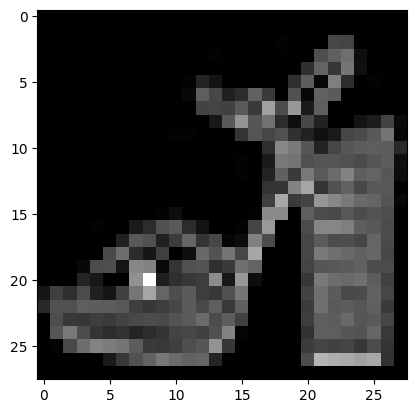

In [13]:
plt.imshow(x.squeeze(), cmap="gray")

In [14]:
Y

tensor([5, 0, 0, 2, 9, 8, 0, 8, 1, 1, 3, 2, 8, 0, 2, 5])

# Model

In [15]:
class ConvNet(nn.Module):
  '''
    Simple Convolutional Neural Network
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Conv2d(channels, 16, kernel_size=3, padding="same"),
      nn.BatchNorm2d(16),
      nn.MaxPool2d(kernel_size=2),
      nn.ReLU(),
      nn.Conv2d(16, 32, kernel_size=3, padding="same"),
      nn.BatchNorm2d(32),
      nn.MaxPool2d(kernel_size=2),
      nn.ReLU(),
      nn.Flatten(),
      nn.Dropout(p=0.2, inplace=False),
      nn.Linear(width * height * 32 // 16, 64),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Linear(32, 10)
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

# Tensorboard 

In [16]:
%rm -rf ./logs
# writer = SummaryWriter("./logs")

## Model Grapph

In [17]:
# tensorboard_write_graph(writer=writer, model=ConvNet(), x=X)

# Hyper Parameters

In [18]:
batch_sizes: List[int] = [
    8, 16, 32, 64
]
learning_rates: List[float] = [
    1e-3, 1e-4, 1e-5
]
beta1s: List[float] = [
    0.85, 0.9, 0.95
]
beta2s: List[float] = [
    0.9985, 0.999, 0.9995
]
decays: List[float] = [
    0.005, 0.01, 0.015
]

# Training Loop

In [19]:
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
NUM_EPOCHS: int = 5

In [ ]:
for lr, beta1, beta2, decay in product(learning_rates, beta1s, beta2s, decays):
    print()
    print('-' * 80)
    print(f"lr:{lr} beat1:{beta1} beta2:{beta2} decay:{decay}")
    print('-' * 80)

    # --------------------------------------------------------------------------------
    # Initialize for each parameter combination.
    # --------------------------------------------------------------------------------
    prev_loss: float = float(sys.maxsize)
    early_stop_tolerance: int = 3

    run_name: str = f"./logs/lr{lr}_beat1{beta1}_beta2{beta2}_decay{decay}"
    writer = SummaryWriter(run_name)

    model: nn.Module = ConvNet()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(beta1, beta2), weight_decay=decay)
    loss_fn = nn.CrossEntropyLoss(reduction='mean')   # normalized by batch size

    # --------------------------------------------------------------------------------
    # Train for each parameter combination.
    # --------------------------------------------------------------------------------
    for epoch in range(0, NUM_EPOCHS):   # epochs at maximum
        tensorboard_write_histogram(writer=writer, model=model, step=epoch)
    
        # Print epoch
        print(f'Starting epoch:[{epoch}].')
    
        # Reset current loss value at eacch epoch
        _current_loss: float = 0.0
        _num_records: int = 0
    
        # Iterate over the DataLoader for training data
        model.train(True)
        for index, data in enumerate(train_loader, 0):
            inputs, targets = data
            _batch_size: int = len(inputs)
    
            # Write an image at every batch 0
            if index == 0:
                tensorboard_write_image(
                    writer=writer, tag="image", image=inputs[0], step=epoch, dataformats="CHW"
                )
    
            # Zero the gradients
            optimizer.zero_grad()
    
            # Perform forward pass
            outputs = model(inputs)
    
            # Compute loss
            loss = loss_fn(outputs, targets)
    
            # Perform backward pass
            loss.backward()
    
            # Perform optimization
            optimizer.step()
    
            # Print statistics
            _current_loss += loss.item()
    
            if index % 1000 == 0:
                print(f'training loss at batch:[{index:05d}]: {_current_loss / (index + 1):.03f}')

            # if index > 209: break

        # --------------------------------------------------------------------------------
        # Reports per epoch
        # --------------------------------------------------------------------------------
        model.eval()

        # Loss
        tensorboard_write_scalar(
            writer=writer, tag="training loss/epoch", value=_current_loss / (index + 1), step=epoch
        )
    
        # Validation accuracy & confusion matrix
        inputs = labels = predictions = None
        with torch.no_grad():
            inputs, labels = next(iter(val_loader))
            # predictions = torch.argmax(model(inputs), axis=-1) # No need to argmax
            predictions = model(inputs)
            # val_loss = loss_fn(predictions.to(torch.float), labels.to(torch.float)) / len(labels)
            val_loss = loss_fn(predictions, labels)

        val_acc = get_accuracy(predictions=predictions, truth=labels)
    
        tensorboard_write_scalar(
            writer=writer, tag="validation loss/epoch", value=val_loss, step=epoch
        )
        tensorboard_write_scalar(
            writer=writer, tag="validation accuracy/epoch", value=val_acc, step=epoch
        )
        tensorboard_write_confusion_matrix(
            writer=writer,
            tag="validation confusion matrix",
            predictions=torch.argmax(predictions, axis=-1),
            truth=labels,
            class_names=list(id_to_label.values()),
            step=epoch
        )
        print(f'val_acc {val_acc:.03f} val_loss {val_loss: .03f}')
        writer.flush()

        # --------------------------------------------------------------------------------
        # Early stop
        # --------------------------------------------------------------------------------
        if val_loss > prev_loss:
            early_stop_tolerance -= 1
        else:
            prev_loss = val_loss
    
        if early_stop_tolerance <= 0:
            print("early stop")
            break

    # --------------------------------------------------------------------------------
    # Test
    # --------------------------------------------------------------------------------
    inputs = labels = predictions = None
    with torch.no_grad():
        inputs, labels = next(iter(test_loader))
        predictions = model(inputs)

    test_loss = loss_fn(predictions, labels)
    test_acc = get_accuracy(predictions=predictions, truth=labels)
    print(f'test_acc {test_acc:.03f} test_loss {test_loss: .03f}')

    tensorboard_write_scalar(
        writer=writer, tag="test loss/epoch", value=test_loss, step=epoch
    )
    tensorboard_write_scalar(
        writer=writer, tag="test accuracy/epoch", value=test_acc, step=epoch
    )
    tensorboard_write_confusion_matrix(
        writer=writer,
        tag="test confusion matrix",
        predictions=torch.argmax(predictions, axis=-1),
        truth=labels,
        class_names=list(id_to_label.values()),
        step=epoch
    )
    writer.add_hparams(
        hparam_dict={"lr": lr, "beta1": beta1, "beta2": beta2, "decay": decay},
        metric_dict={
            "test_accuracy": test_acc,
            "test_loss": test_loss,
        },
        run_name=run_name,
    )
    writer.flush()

# Process is complete.
print('Training process has finished.')


--------------------------------------------------------------------------------
lr:0.001 beat1:0.85 beta2:0.9985 decay:0.005
--------------------------------------------------------------------------------
Starting epoch:[0].
training loss at batch:[00000]: 2.261
training loss at batch:[01000]: 0.537
training loss at batch:[02000]: 0.462
val_acc 0.886 val_loss  0.315
Starting epoch:[1].
training loss at batch:[00000]: 0.206
training loss at batch:[01000]: 0.319
training loss at batch:[02000]: 0.316
val_acc 0.903 val_loss  0.273
Starting epoch:[2].
training loss at batch:[00000]: 0.210
training loss at batch:[01000]: 0.283
training loss at batch:[02000]: 0.280
val_acc 0.900 val_loss  0.274
Starting epoch:[3].
training loss at batch:[00000]: 0.209
training loss at batch:[01000]: 0.258
training loss at batch:[02000]: 0.260
val_acc 0.905 val_loss  0.260
Starting epoch:[4].
training loss at batch:[00000]: 0.212
training loss at batch:[01000]: 0.236
training loss at batch:[02000]: 0.239
va

# Confusion Matrix

In [ ]:
with torch.no_grad():
    inputs, labels = next(iter(test_loader))
    predictions = model(inputs)

In [ ]:
labels = labels.numpy()
predictions = np.argmax(predictions.numpy(), axis=-1).squeeze()

In [ ]:
tensorboard_write_confusion_matrix(
    writer=writer,
    tag="confusion matrix",
    predictions=predictions,
    truth=labels,
    class_names=list(id_to_label.values()),
    step=1
)

# Tensorboard

In [ ]:
%tensorboard --logdir ./logs/